In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go

from prophet import Prophet
import xgboost as xgb
# from catboost import CatBoostRegressor
from xgboost import plot_importance, plot_tree

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Загрузим датасет.

In [3]:
train = pd.read_csv('data/train.zip')

train.head()

C:\Users\saakyan.ag\AppData\Local\Temp\ipykernel_4112\3344748158.py:1: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

In [4]:
df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()

df.head()

date  unit_sales
0  2013-01-01    2511.619
1  2013-01-02    5316.224
2  2013-01-03    4442.913
3  2013-01-04    4844.354
4  2013-01-05    5817.526

In [5]:
# приводим индексы к стандарту pd.Datetime, чтобы потом это можно было скормить seasonal_decompose
df = df.set_index(pd.DatetimeIndex(df['date'])) 
df.head() # смотрим на результат

date  unit_sales
date                              
2013-01-01  2013-01-01    2511.619
2013-01-02  2013-01-02    5316.224
2013-01-03  2013-01-03    4442.913
2013-01-04  2013-01-04    4844.354
2013-01-05  2013-01-05    5817.526

In [6]:
 # замечаем, что т.к. у нас теперь есть индекс Month, нам больше не нужен столбец Month, который его дублирует
df = df.drop(['date'], axis = 1)
df.head() # снова проверяем, что все в порядке. вообще проверять данные на каждом шаге кода - хорошая привыч

unit_sales
date                  
2013-01-01    2511.619
2013-01-02    5316.224
2013-01-03    4442.913
2013-01-04    4844.354
2013-01-05    5817.526

In [7]:
df.sort_index(inplace= True)

# Применяем seasonal_decompose
Функция разложит ряд на трендовую, сезонную и шумовую составляющие

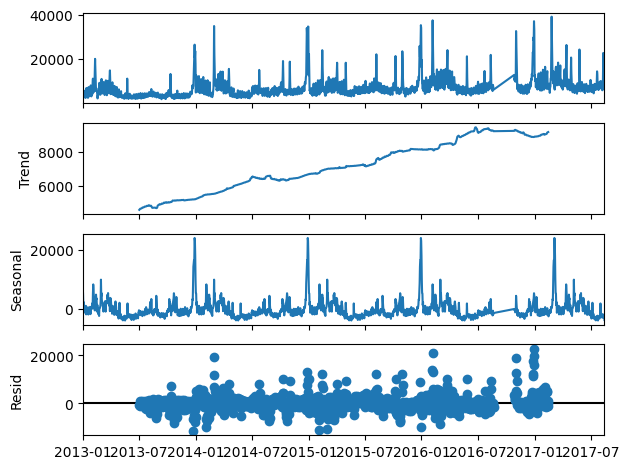

In [8]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(df, model='additive', period=365) 
decomposition.plot()
plt.show() # любуемся результатом

In [9]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

Посмотрим число трендовых компонент

In [10]:
trend_part.notna().sum()

1254

Посмотрим число сезонных компонент:

In [11]:
seasonal_part.notna().sum()

1618

Посмотрим число шумовых компонент:

In [12]:
residual_part.notna().sum()

1254

## Анализ результата:

В ряде явно присутствует тренд на рост и ярко выражена годовая сезонность
Остатки ряда похожи на хаотичный белый шум и скорее всего все еще содержат закономерности

# Выполним тест Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.8589926653181825
p-value:  4.1883941929077364e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

In [16]:
train_test_groups = tscv.split(df.unit_sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 1597 TEST size: 7
TRAIN size: 1604 TEST size: 7
TRAIN size: 1611 TEST size: 7


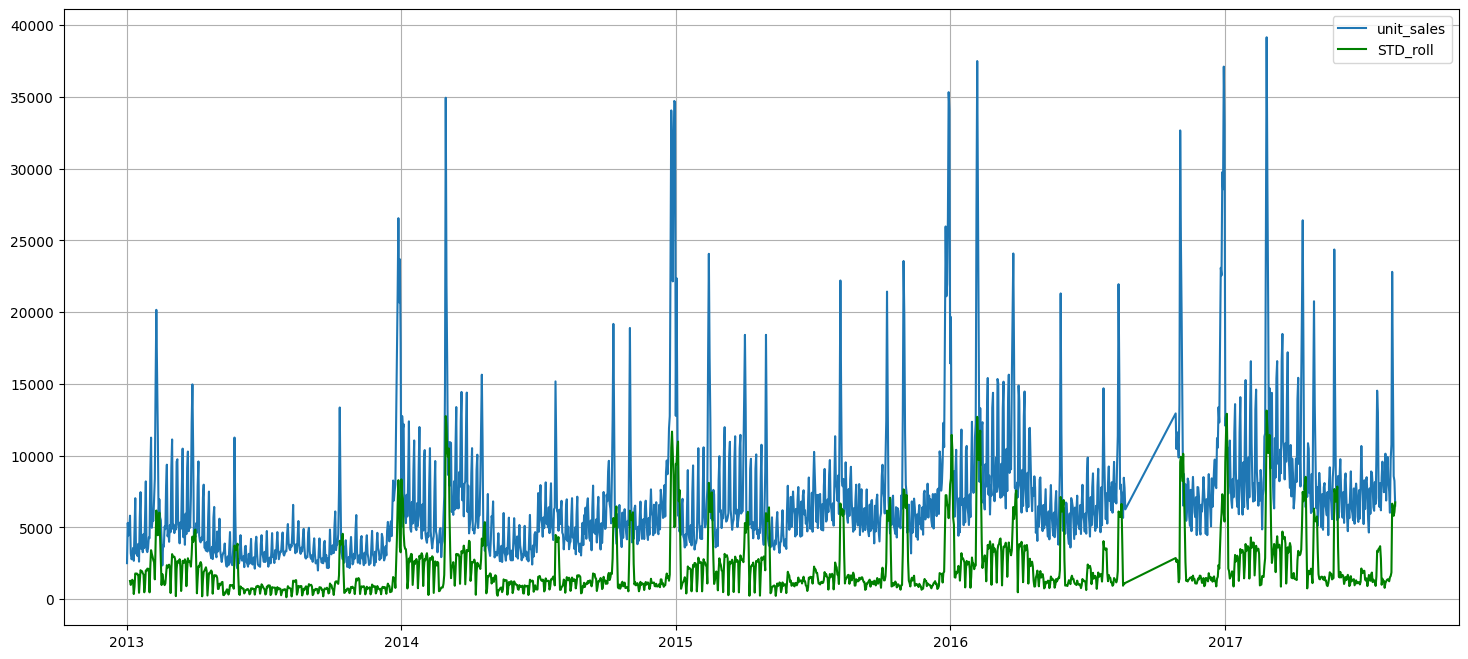

In [17]:
df['std_rolling'] = df.unit_sales.rolling(window=5).std()

# визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные
ax.plot(df.index, df['std_rolling'],  c='g') # оконное стандартное отклонение
ax.legend(['unit_sales', 'STD_roll'])
ax.grid()

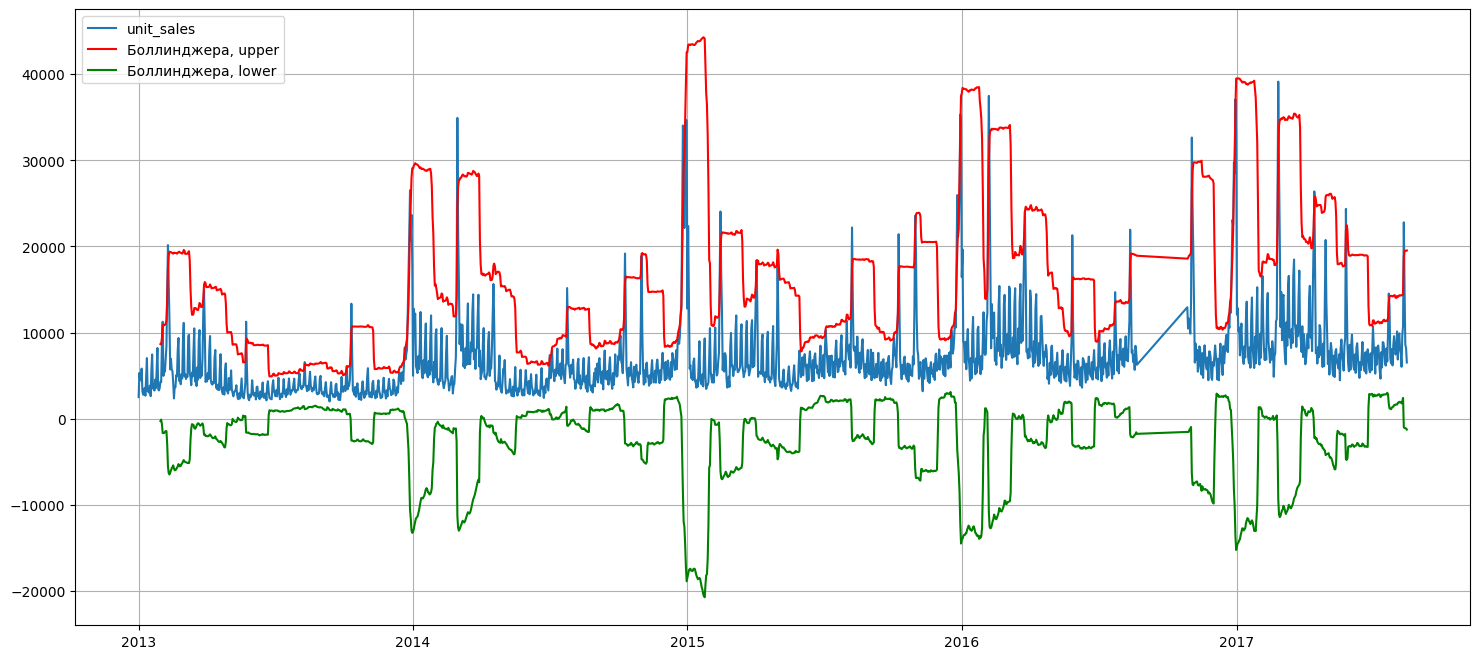

In [18]:
df['rolling_std'] = df.unit_sales.rolling(window=30).std()
df['rolling_mean'] = df.unit_sales.rolling(window=30).mean()
df['upper'] = df['rolling_mean'] + 3 * df['rolling_std']
df['lower'] = df['rolling_mean'] - 3 * df['rolling_std']

# визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные
ax.plot(df.index, df['upper'],  c='r') # верхняя линия Боллинджера
ax.plot(df.index, df['lower'],  c='g') # нижняя линия Боллинджера
ax.legend(['unit_sales', 'Боллинджера, upper', 'Боллинджера, lower'])
ax.grid()

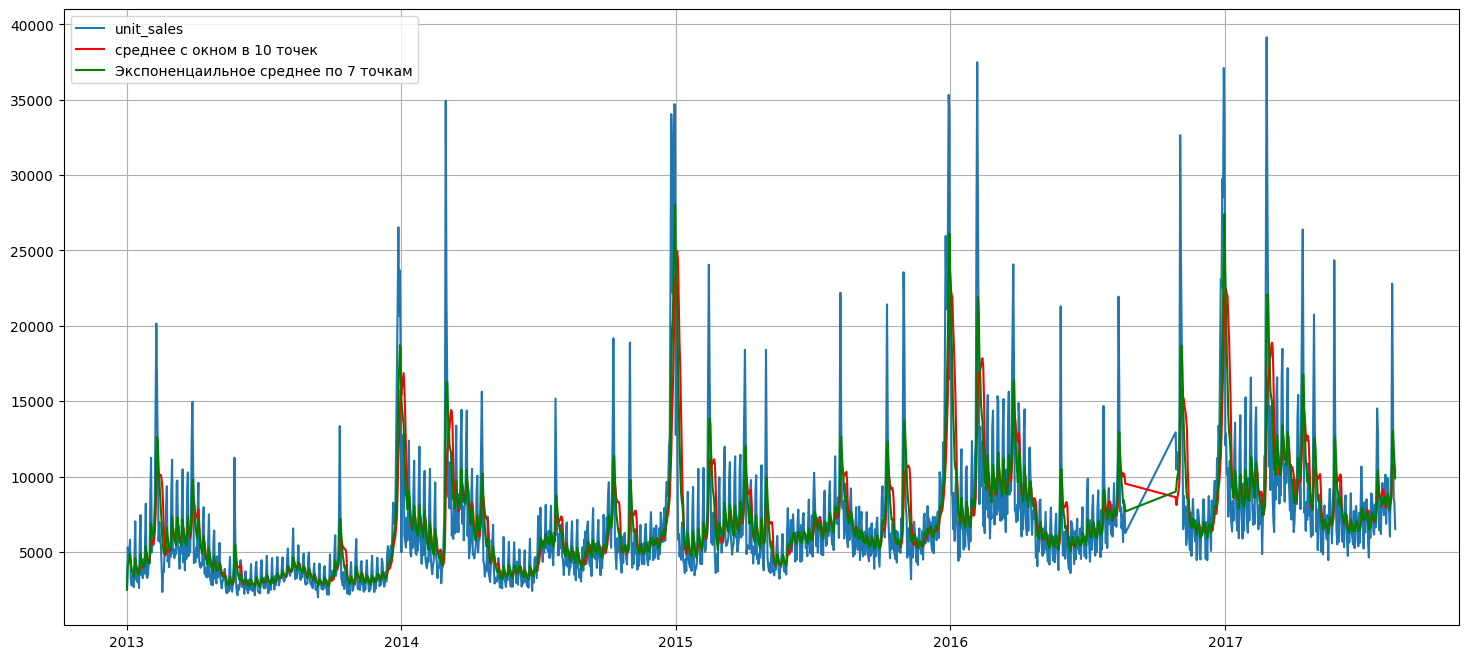

In [19]:
df['rolling_mean10'] = df.unit_sales.rolling(window=10).mean()
df['ewm7'] = df.unit_sales.ewm(span=7).mean()

# визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные
ax.plot(df.index, df['rolling_mean10'],  c='r') # оконное среднее на 10 точках
ax.plot(df.index, df['ewm7'],  c='g') # оконное экспоненцаильное среднее по 7 точкам
ax.legend(['unit_sales', 'среднее с окном в 10 точек','Экспоненцаильное среднее по 7 точкам'])
ax.grid()

In [20]:
def min_max_mean(value):
    """Функция возвращает среднее арифметическим между максимальным и минимальным значением

    Args:
        value (iterable): входные значения
    """
    return (min(value) + max(value)) / 2

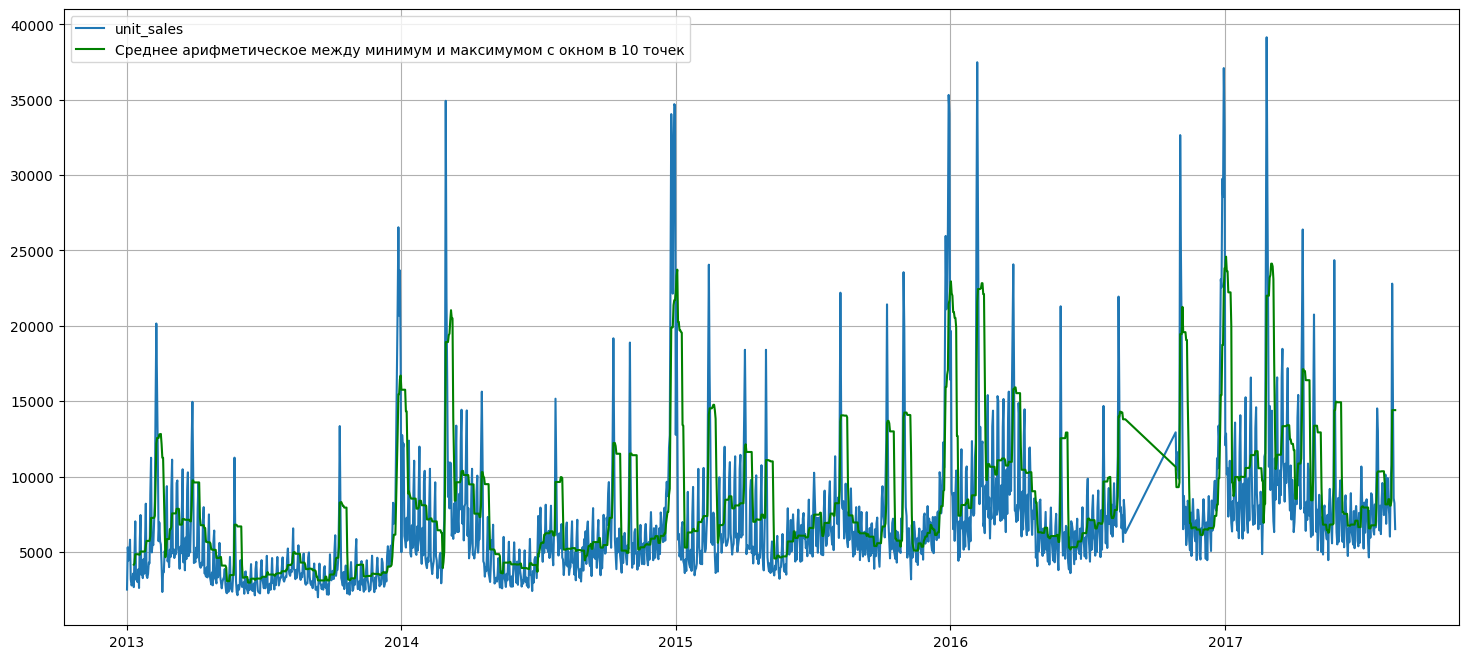

In [21]:
df['min_max_mean'] = df.unit_sales.rolling(window=10).apply(min_max_mean)

# визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные
ax.plot(df.index, df['min_max_mean'],  c='g') # оконное min_max_mean с окном в 10 точек
ax.legend(['unit_sales', 'Среднее арифметическое между минимум и максимумом с окном в 10 точек'])
ax.grid()

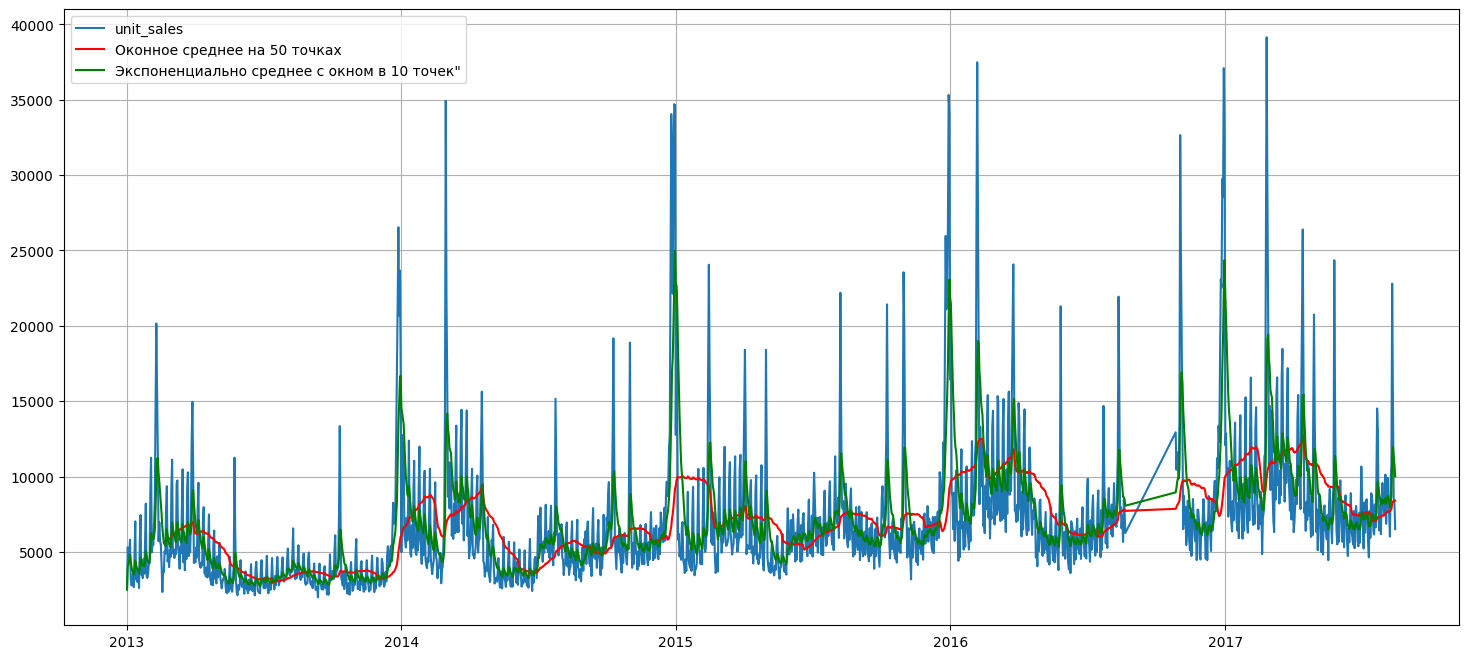

In [22]:
df['rolling_mean50'] = df.unit_sales.rolling(window=50).mean()
df['ewm10'] = df.unit_sales.ewm(span=10).mean()

# визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные
ax.plot(df.index, df['rolling_mean50'],  c='r') # оконное среднее на 50 точках
ax.plot(df.index, df['ewm10'],  c='g') # оконное среднее
ax.legend(['unit_sales', 'Оконное среднее на 50 точках','Экспоненциально среднее с окном в 10 точек"'])
ax.grid()

## Укажем индексы датафрейма, на которых одно скользящее пересекается с другим.

In [23]:
df['diff'] = np.sign(df['rolling_mean50'] - df['ewm10']).diff()

df[(df['diff'] != 0) & (df['diff'].notna())].index

DatetimeIndex(['2013-02-20', '2013-02-22', '2013-02-26', '2013-03-02',
               '2013-03-05', '2013-03-09', '2013-03-11', '2013-03-16',
               '2013-03-17', '2013-03-23',
               ...
               '2017-04-19', '2017-04-29', '2017-05-02', '2017-05-26',
               '2017-05-30', '2017-06-03', '2017-06-05', '2017-07-02',
               '2017-07-04', '2017-07-15'],
              dtype='datetime64[ns]', name='date', length=128, freq=None)

## Построим лаговые факторы с 7 по 10:

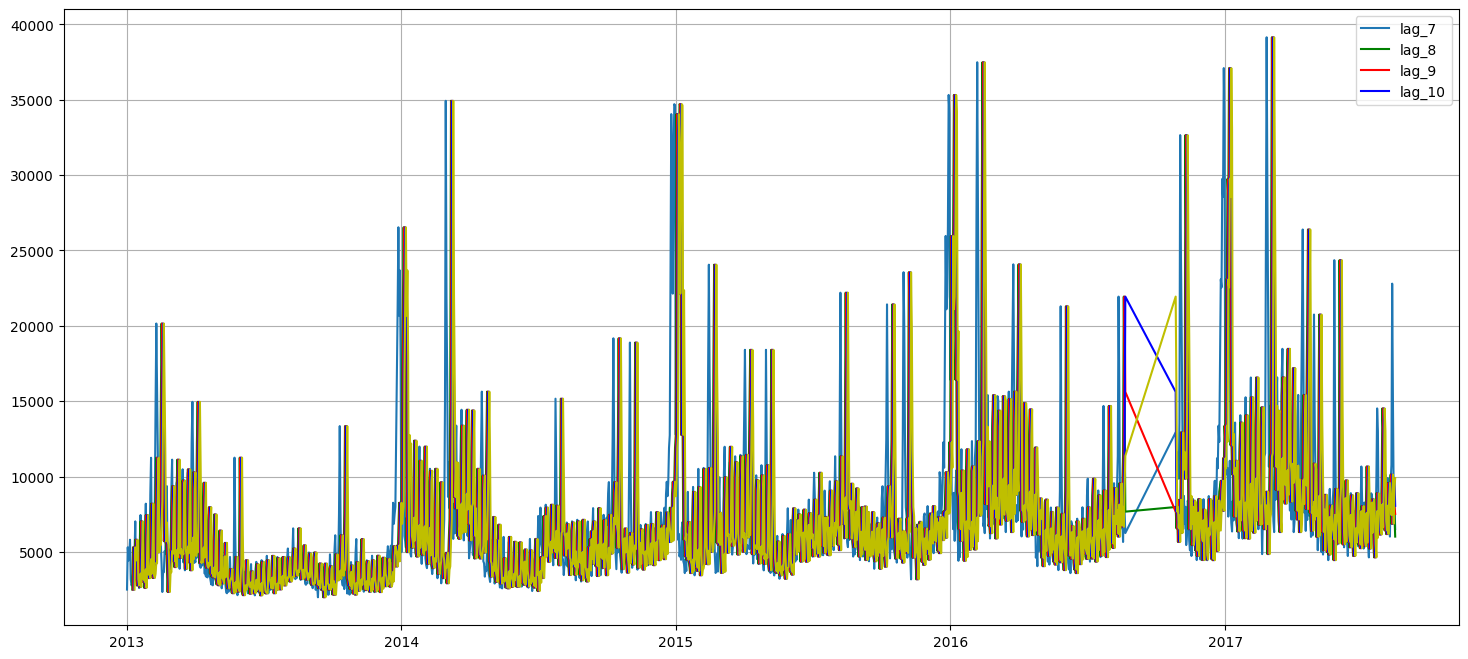

In [24]:

f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.index, df.unit_sales) # исходные данные

for lag, color in zip(range(7,11), ['g','r','b','y']):
    df['lag_{}'.format(lag)] = df.unit_sales.shift(lag)
    ax.plot(df.index, df['lag_' + str(lag)],  c=color) 


# визуализируем
ax.legend([f'lag_{lag}' for lag in range(7,11)])
ax.grid()

In [25]:

df_ = train[train.item_nbr == 103501]
df_['date'] = pd.to_datetime(df_['date'])
df_ = train[train.store_nbr==25].groupby("date").sum()['unit_sales']

C:\Users\saakyan.ag\AppData\Local\Temp\ipykernel_4112\1989076296.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df_

date
2013-01-01     2511.619
2013-01-02     5316.224
2013-01-03     4442.913
2013-01-04     4844.354
2013-01-05     5817.526
                ...    
2017-08-11    22800.841
2017-08-12    15090.753
2017-08-13     8570.598
2017-08-14     8244.854
2017-08-15     6522.788
Name: unit_sales, Length: 1618, dtype: float64

In [27]:
test = adfuller(df_)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.8589926653181825
p-value:  4.1883941929077364e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


## Модель скользящего среднего

Реализуем модель скользящего среднего. За окно попробуем взять 6 дней. После чего сравним результат с последними 6 днями, которые не использовали в рассчете скользящего среднего. Вы можете сравнить результат с другим размером окна.

(6, 1) (6,)
mean_squared_error 47782667.88788555
mean_absolute_error 5685.58836111111
mean_absolute_error 0.48625055948648116


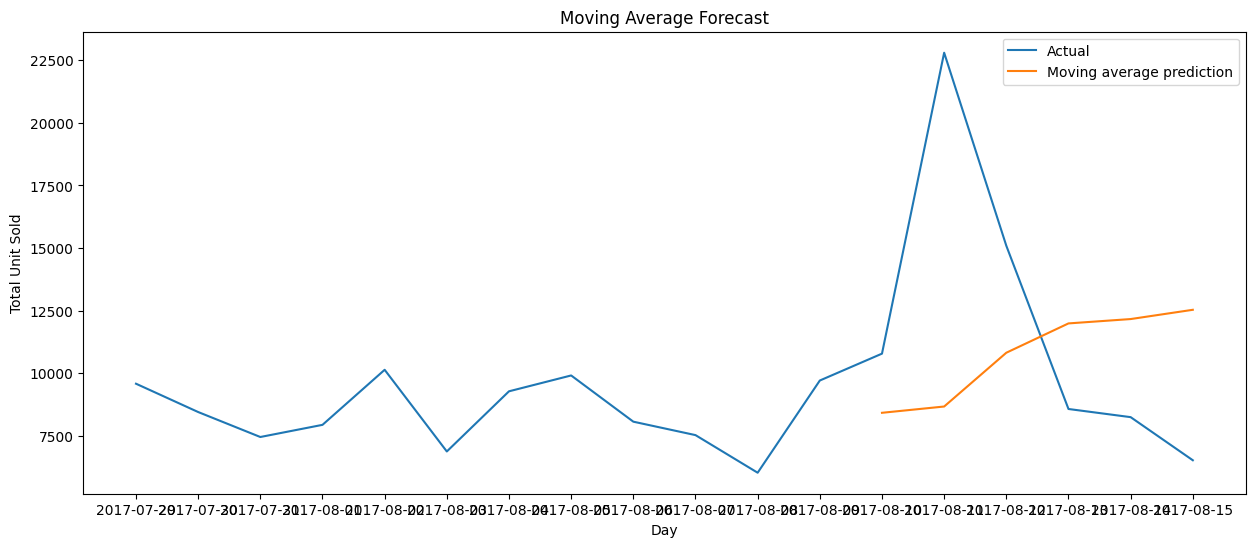

In [28]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(df_, moving_average_days )
moving_avg = pd.DataFrame(moving_avg, index = df_[moving_average_days:].index)

print(moving_avg[-moving_average_days:].shape, df_[-moving_average_days:].shape)

print("mean_squared_error",mean_squared_error(df_.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_error(df_.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_percentage_error(df_.values[-moving_average_days:], moving_avg[-moving_average_days:]))

plt.figure(figsize=(15,6))

plt.plot(df_[- shown_train_size:], label="Actual")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

[ 0.77263992 -0.07397669 -0.02550426  0.04370662 -0.02875481 -0.04182832
  0.2071591 ]
1037.7195315107501
mean_squared_error 29629609.630035162
mean_absolute_error 3929.725592727433
mean_absolute_error 0.2918361300518951


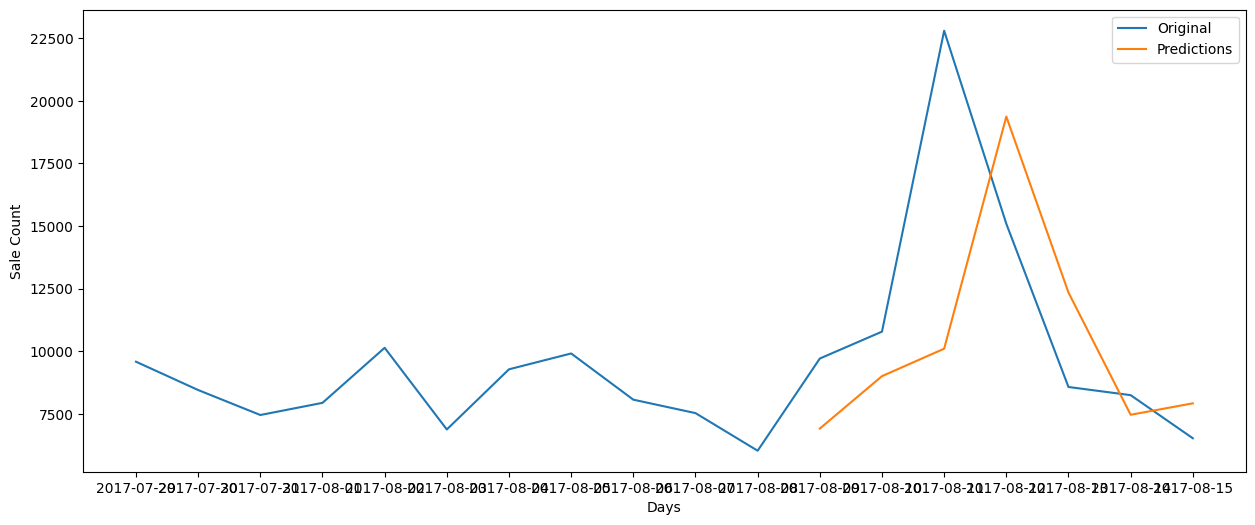

In [29]:
predict_size = 7
df__ = pd.DataFrame()

df__["Original Values"]  = df_.copy()
df__["shift1"] = df__["Original Values"].shift()
df__["shift2"] = df__["shift1"].shift()
df__["shift3"] = df__["shift2"].shift()
df__["shift4"] = df__["shift3"].shift()
df__["shift5"] = df__["shift4"].shift()
df__["shift6"] = df__["shift5"].shift()
df__["shift8"] = df__["shift6"].shift()
df__.dropna(inplace=True)

x_train, y_train = df__[:-predict_size].drop(["Original Values"], axis =1), df__[:-predict_size]["Original Values"]
x_test, y_test  = df__[-predict_size:].drop(["Original Values"], axis =1), df__[-predict_size:]["Original Values"]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = pd.DataFrame(reg.predict(x_test), index=x_test.index)

plt.figure(figsize=(15,6))
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.plot(ar_predictions ,label = "Predictions")
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_percentage_error(y_test, ar_predictions))


plt.legend(loc="upper right")

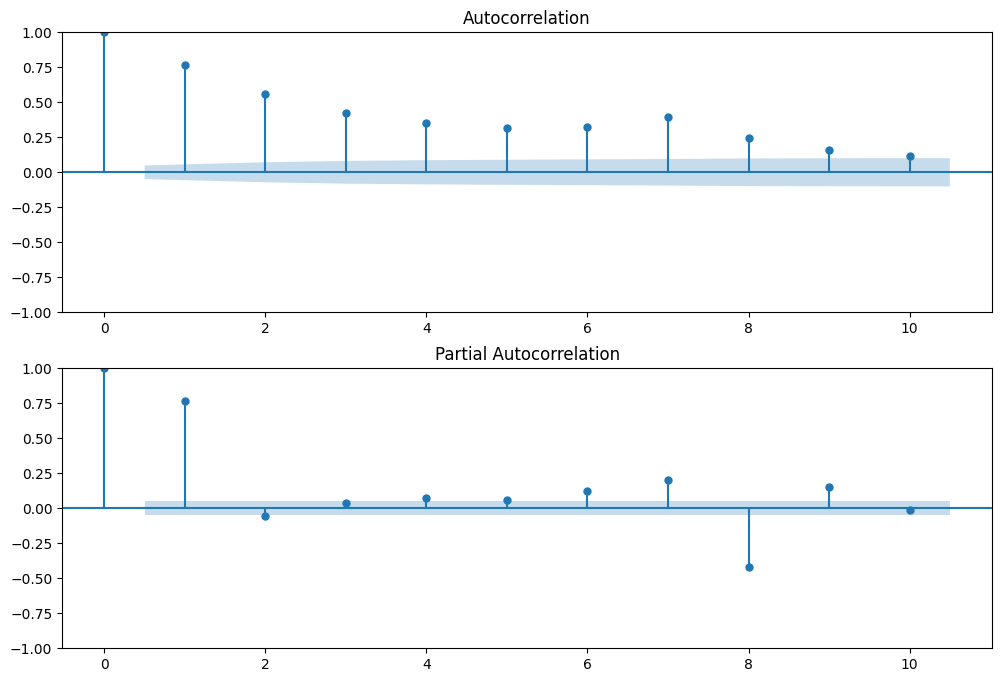

In [30]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_, lags=10, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 7, т.к. на ней все лаги сильно отличны от нуля.
По коррелограмме ACF можно предположить, что q = 7, т.к. на лаг 7 значении функций резко возрастает. Итак, когда известны все параметры можно построить модель.

## Выводы:

В данном случае обычная линейная регрессия показала себя лучше, чем модель скользящего среднего.

# Prophet

In [31]:
py.init_notebook_mode()

In [32]:
transactions = train.groupby('date')['unit_sales'].sum()

transactions.head()

date
2013-01-01      2511.619
2013-01-02    496092.418
2013-01-03    361429.231
2013-01-04    354459.677
2013-01-05    477350.121
Name: unit_sales, dtype: float64

In [33]:
py.iplot([go.Scatter(
    x=transactions.index,
    y=transactions
)])

Сделаем предсказание без настроек с помощью Пророка

In [34]:
transactions = pd.DataFrame({
        'ds':transactions.index,
        'y': transactions.values
    })

transactions.head()

ds           y
0  2013-01-01    2511.619
1  2013-01-02  496092.418
2  2013-01-03  361429.231
3  2013-01-04  354459.677
4  2013-01-05  477350.121

In [35]:
m = Prophet()
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast

08:55:39 - cmdstanpy - INFO - Chain [1] start processing
08:55:39 - cmdstanpy - INFO - Chain [1] done processing


ds          trend     yhat_lower    yhat_upper    trend_lower  \
0    2013-01-01  334339.557973  235358.254053  5.180987e+05  334339.557973   
1    2013-01-02  334709.425078  243816.415948  5.182343e+05  334709.425078   
2    2013-01-03  335079.292184  156021.344947  4.252171e+05  335079.292184   
3    2013-01-04  335449.159289  222302.087129  4.944540e+05  335449.159289   
4    2013-01-05  335819.026395  399266.790319  6.746124e+05  335819.026395   
...         ...            ...            ...           ...            ...   
2044 2018-08-11  992940.440847  903082.052621  1.198190e+06  933033.358544   
2045 2018-08-12  993209.047680  957550.779590  1.243131e+06  932959.755528   
2046 2018-08-13  993477.654513  743425.166209  1.042529e+06  932898.138667   
2047 2018-08-14  993746.261346  702594.198467  1.009187e+06  932867.167920   
2048 2018-08-15  994014.868180  718416.136831  1.034162e+06  932737.838815   

       trend_upper  additive_terms  additive_terms_lower  \
0     3.343396e+05    43479.595164          43479.595164   
1     3.347094e+05    55521.983079          55521.983079   
2     3.350793e+05   -44091.993238         -44091.993238   
3     3.354492e+05    18980.476919          18980.476919   
4     3.358190e+05   198563.733324         198563.733324   
...            ...             ...                   ...   
2044  1.040117e+06    62507.821270          62507.821270   
2045  1.040693e+06   116406.034755         116406.034755   
2046  1.041188e+06   -92974.081792         -92974.081792   
2047  1.041686e+06  -139173.462331        -139173.462331   
2048  1.042205e+06  -113751.597821        -113751.597821   

      additive_terms_upper         weekly   weekly_lower   weekly_upper  \
0             43479.595164  -68157.942659  -68157.942659  -68157.942659   
1             55521.983079  -44199.968067  -44199.968067  -44199.968067   
2            -44091.993238 -131878.686822 -131878.686822 -131878.686822   
3             18980.476919  -57029.549952  -57029.549952  -57029.549952   
4            198563.733324  134003.618265  134003.618265  134003.618265   
...                    ...            ...            ...            ...   
2044          62507.821270  134003.618264  134003.618264  134003.618264   
2045         116406.034755  188401.650111  188401.650111  188401.650111   
2046         -92974.081792  -21139.120876  -21139.120876  -21139.120876   
2047        -139173.462331  -68157.942659  -68157.942659  -68157.942659   
2048        -113751.597821  -44199.968067  -44199.968067  -44199.968067   

             yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0     111637.537823  111637.537823  111637.537823                   0.0   
1      99721.951145   99721.951145   99721.951145                   0.0   
2      87786.693584   87786.693584   87786.693584                   0.0   
3      76010.026870   76010.026870   76010.026870                   0.0   
4      64560.115060   64560.115060   64560.115060                   0.0   
...             ...            ...            ...                   ...   
2044  -71495.796994  -71495.796994  -71495.796994                   0.0   
2045  -71995.615356  -71995.615356  -71995.615356                   0.0   
2046  -71834.960916  -71834.960916  -71834.960916                   0.0   
2047  -71015.519672  -71015.519672  -71015.519672                   0.0   
2048  -69551.629755  -69551.629755  -69551.629755                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  3.778192e+05  
1                            0.0                         0.0  3.902314e+05  
2                            0.0                         0.0  2.909873e+05  
3                            0.0                         0.0  3.544296e+05  
4                            0.0                         0.0  5.343828e+05  
...                          ...                         ...           ...  
2044          

In [36]:
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [37]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )

RMSE: 107824.776579


Подберем наиболее подходящий параметр "changepoint_prior_scale"

In [38]:
min_rmse = np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2))
for scale in np.arange(2,7,0.1):
    m = Prophet(changepoint_prior_scale=scale)
    m.fit(transactions)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    tmp_rmse = np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2))
    if tmp_rmse < min_rmse:
        min_rmse = tmp_rmse
        min_scale = scale
        
    print(f'With changepoint_prior_scale {scale} RMSE: {np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2))}')

08:55:40 - cmdstanpy - INFO - Chain [1] start processing
08:55:41 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.0 RMSE: 97578.11750034876


08:55:42 - cmdstanpy - INFO - Chain [1] start processing
08:55:43 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.1 RMSE: 97565.16436135606


08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.2 RMSE: 97608.5838633154


08:55:45 - cmdstanpy - INFO - Chain [1] start processing
08:55:45 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.3000000000000003 RMSE: 97493.51188808777


08:55:46 - cmdstanpy - INFO - Chain [1] start processing
08:55:46 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.4000000000000004 RMSE: 97507.15791066471


08:55:47 - cmdstanpy - INFO - Chain [1] start processing
08:55:47 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.5000000000000004 RMSE: 97510.07882199652


08:55:48 - cmdstanpy - INFO - Chain [1] start processing
08:55:49 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.6000000000000005 RMSE: 97432.12434318035


08:55:49 - cmdstanpy - INFO - Chain [1] start processing
08:55:50 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.7000000000000006 RMSE: 97401.81790689826


08:55:51 - cmdstanpy - INFO - Chain [1] start processing
08:55:51 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.8000000000000007 RMSE: 97434.27750425518


08:55:52 - cmdstanpy - INFO - Chain [1] start processing
08:55:53 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 2.900000000000001 RMSE: 97395.99512973818


08:55:53 - cmdstanpy - INFO - Chain [1] start processing
08:55:54 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.000000000000001 RMSE: 97400.40448366647


08:55:55 - cmdstanpy - INFO - Chain [1] start processing
08:55:55 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.100000000000001 RMSE: 97410.84738005494


08:55:56 - cmdstanpy - INFO - Chain [1] start processing
08:55:57 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.200000000000001 RMSE: 97421.61911939975


08:55:57 - cmdstanpy - INFO - Chain [1] start processing
08:55:58 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.300000000000001 RMSE: 97415.77548689183


08:55:59 - cmdstanpy - INFO - Chain [1] start processing
08:55:59 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.4000000000000012 RMSE: 97392.86392142734


08:56:00 - cmdstanpy - INFO - Chain [1] start processing
08:56:01 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.5000000000000013 RMSE: 97407.14515090045


08:56:01 - cmdstanpy - INFO - Chain [1] start processing
08:56:02 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.6000000000000014 RMSE: 97414.75915923211


08:56:03 - cmdstanpy - INFO - Chain [1] start processing
08:56:03 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.7000000000000015 RMSE: 97422.88959959112


08:56:04 - cmdstanpy - INFO - Chain [1] start processing
08:56:04 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.8000000000000016 RMSE: 97359.90778802166


08:56:05 - cmdstanpy - INFO - Chain [1] start processing
08:56:06 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 3.9000000000000017 RMSE: 97413.8924153251


08:56:06 - cmdstanpy - INFO - Chain [1] start processing
08:56:07 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.000000000000002 RMSE: 97403.53559611543


08:56:08 - cmdstanpy - INFO - Chain [1] start processing
08:56:08 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.100000000000001 RMSE: 97522.89060569108


08:56:09 - cmdstanpy - INFO - Chain [1] start processing
08:56:10 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.200000000000002 RMSE: 97335.6070759581


08:56:10 - cmdstanpy - INFO - Chain [1] start processing
08:56:11 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.3000000000000025 RMSE: 97370.28911032685


08:56:12 - cmdstanpy - INFO - Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.400000000000002 RMSE: 97352.45554100575


08:56:13 - cmdstanpy - INFO - Chain [1] start processing
08:56:13 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.500000000000002 RMSE: 97440.57284336461


08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:14 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.600000000000002 RMSE: 97345.01638262105


08:56:15 - cmdstanpy - INFO - Chain [1] start processing
08:56:16 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.700000000000003 RMSE: 97338.675165521


08:56:16 - cmdstanpy - INFO - Chain [1] start processing
08:56:17 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.8000000000000025 RMSE: 97351.29337135734


08:56:18 - cmdstanpy - INFO - Chain [1] start processing
08:56:18 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 4.900000000000002 RMSE: 97340.11217466347


08:56:19 - cmdstanpy - INFO - Chain [1] start processing
08:56:20 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.000000000000003 RMSE: 97338.82598279453


08:56:20 - cmdstanpy - INFO - Chain [1] start processing
08:56:21 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.100000000000003 RMSE: 97372.43275563951


08:56:22 - cmdstanpy - INFO - Chain [1] start processing
08:56:22 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.200000000000003 RMSE: 97372.80376217628


08:56:23 - cmdstanpy - INFO - Chain [1] start processing
08:56:23 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.3000000000000025 RMSE: 97382.19018908069


08:56:24 - cmdstanpy - INFO - Chain [1] start processing
08:56:24 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.400000000000003 RMSE: 97299.21412736243


08:56:25 - cmdstanpy - INFO - Chain [1] start processing
08:56:26 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.5000000000000036 RMSE: 97316.60469134095


08:56:27 - cmdstanpy - INFO - Chain [1] start processing
08:56:27 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.600000000000003 RMSE: 97380.25879199502


08:56:28 - cmdstanpy - INFO - Chain [1] start processing
08:56:28 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.700000000000003 RMSE: 97353.96492442157


08:56:29 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.800000000000003 RMSE: 97360.83161652104


08:56:30 - cmdstanpy - INFO - Chain [1] start processing
08:56:31 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 5.900000000000004 RMSE: 97313.4043946353


08:56:32 - cmdstanpy - INFO - Chain [1] start processing
08:56:32 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.0000000000000036 RMSE: 97317.95663018979


08:56:33 - cmdstanpy - INFO - Chain [1] start processing
08:56:33 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.100000000000003 RMSE: 97311.09495632899


08:56:34 - cmdstanpy - INFO - Chain [1] start processing
08:56:35 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.200000000000004 RMSE: 97295.12633628384


08:56:35 - cmdstanpy - INFO - Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.300000000000004 RMSE: 97322.96774886845


08:56:36 - cmdstanpy - INFO - Chain [1] start processing
08:56:37 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.400000000000004 RMSE: 97313.42845047577


08:56:38 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.5000000000000036 RMSE: 97304.49833115045


08:56:39 - cmdstanpy - INFO - Chain [1] start processing
08:56:39 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.600000000000004 RMSE: 97374.3343738745


08:56:40 - cmdstanpy - INFO - Chain [1] start processing
08:56:41 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.700000000000005 RMSE: 97347.19760922583


08:56:41 - cmdstanpy - INFO - Chain [1] start processing
08:56:42 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.800000000000004 RMSE: 97311.32751845922


08:56:43 - cmdstanpy - INFO - Chain [1] start processing
08:56:43 - cmdstanpy - INFO - Chain [1] done processing


With changepoint_prior_scale 6.900000000000004 RMSE: 97362.72420788059


In [39]:
m = Prophet(changepoint_prior_scale=min_scale)
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
tmp_rmse = np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2))

08:56:44 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
min_scale

6.200000000000004

In [41]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

RMSE: 97295.126336


c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [42]:
df_holidays_events = pd.read_csv('data/holidays_events.zip')

df_holidays_events.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [43]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
#holidays['lower_window'] = 0
#holidays['upper_window'] = 0
holidays.head()

holiday          ds
0             Fundacion de Manta  2012-03-02
1  Provincializacion de Cotopaxi  2012-04-01
2            Fundacion de Cuenca  2012-04-12
3      Cantonizacion de Libertad  2012-04-14
4      Cantonizacion de Riobamba  2012-04-21

In [44]:
m = Prophet(changepoint_prior_scale=2.5, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

08:56:47 - cmdstanpy - INFO - Chain [1] start processing
08:56:49 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

RMSE: 74168.147742


c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Выводы:

Использована более сложная модель Пророка. С помощью тонких настроек удалось уменьшить ошибку почти в два раза.

In [46]:
transactions.head()

ds           y
0  2013-01-01    2511.619
1  2013-01-02  496092.418
2  2013-01-03  361429.231
3  2013-01-04  354459.677
4  2013-01-05  477350.121

In [47]:
tr = transactions.copy()
tr.index = tr['ds']
tr.drop('ds', axis=1, inplace=True)

In [48]:
split_date = tr.index[-365]

In [49]:
train = tr.loc[tr.index <= split_date].copy()
test = tr.loc[tr.index > split_date].copy()

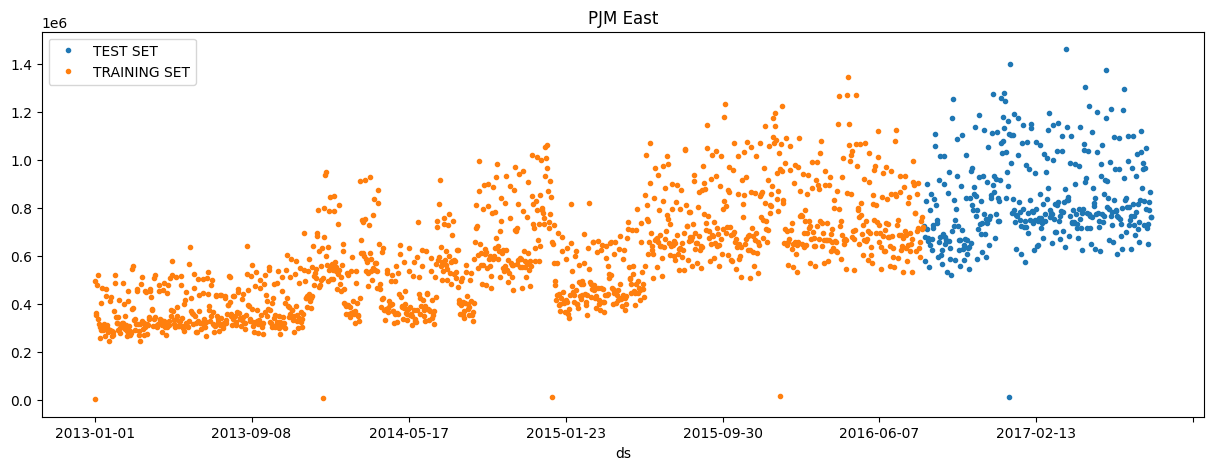

In [50]:
_ = test \
    .rename(columns={'y': 'TEST SET'}) \
    .join(train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [51]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = pd.to_datetime(df.index)
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [52]:
X_train, y_train = create_features(train, label='y')
X_test, y_test = create_features(test, label='y')

In [53]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

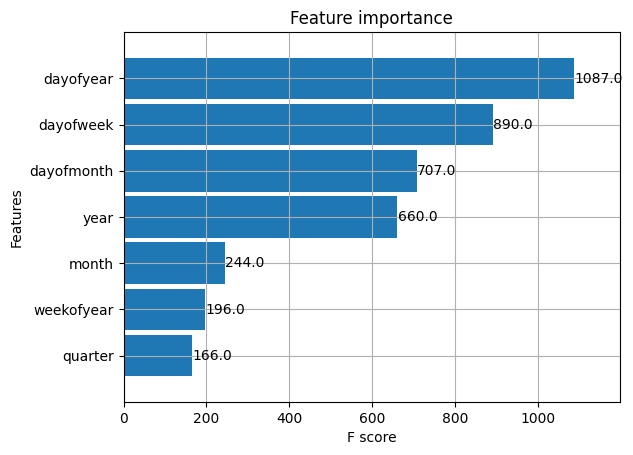

In [54]:
_ = plot_importance(reg, height=0.9)

In [58]:
test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([train, test], sort=False)

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\saakyan.ag\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



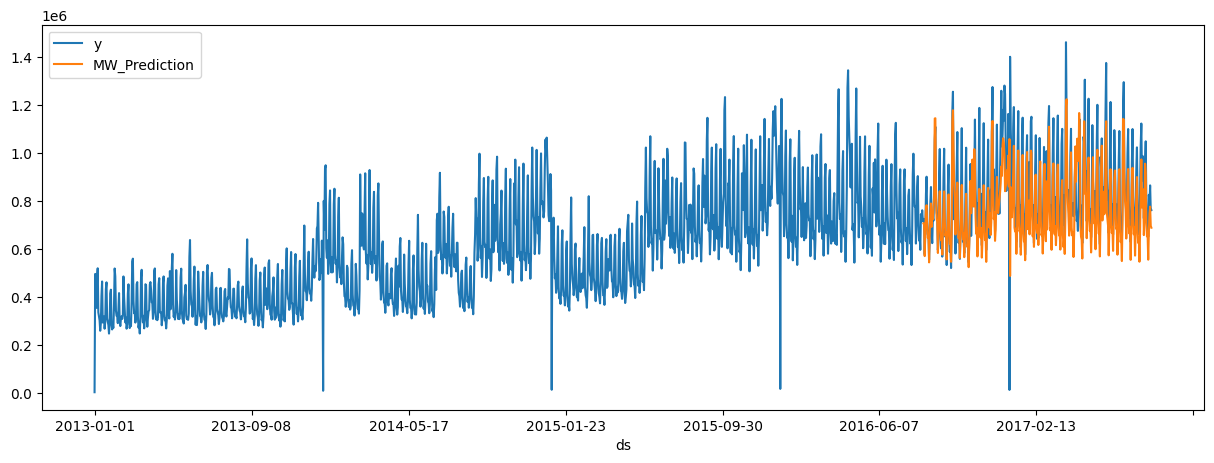

In [59]:
_ = pjme_all[['y','MW_Prediction']].plot(figsize=(15, 5))

In [60]:
mean_squared_error(y_true=test['y'],
                   y_pred=test['MW_Prediction'])

18772336569.395256

In [61]:
mean_absolute_error(y_true=test['y'],
                   y_pred=test['MW_Prediction'])

98911.37609271977

In [67]:
mean_absolute_percentage_error(y_true=test['y'],
                   y_pred=test['MW_Prediction'])

34.53206739151886

### Выводы:

В данном случае градиентный бустинг показал себя хуже Пророка. Явно не хватает дополнительных признаков. Если добавить больше признаков, можно существенно улучшить прогноз.